In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci

import sys
util_dir = "/home/jwdesroches/python/Ga2QuAMES/symmetry/helper_funcs/"
sys.path.append(util_dir)
from utils import *

plt.rcParams.update({'font.size': 16})

In [58]:
import math
from helper_functions import *
from XBK_method import *
from openfermion.utils import count_qubits

#set sampler to perform the annealing
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler() #uses simulated annealing, see D-Wave's ocean sdk for more options

df = pd.read_csv("extracted_data.csv")

In [59]:
mol_name = "LiH"
basis_set = "sto-3g"
charge = 0
spin = 0

bond_lengths = np.around(np.arange(0.3,5.0,0.1),2)
sym_r_values = [1]
nosym_r_values = [1]

In [60]:
fci_bond_lengths = np.linspace(0.3, 5.0, 100)
fci_energies = []
for bond_length in fci_bond_lengths:
    mol = gto.Mole()
    mol.build(atom=return_geometry(mol_name, bond_length), basis=basis_set, unit="angstrom")
    mf = scf.RHF(mol)
    mf.kernel()

    cisolver = fci.FCI(mf)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)

converged SCF energy = -5.84243683078954
converged SCF energy = -6.27596417617278
converged SCF energy = -6.58276376827129
converged SCF energy = -6.81294973745282
converged SCF energy = -6.99447977032092
converged SCF energy = -7.14233748870199
converged SCF energy = -7.26485676556756
converged SCF energy = -7.36734938110659
converged SCF energy = -7.45352595992894
converged SCF energy = -7.52612868622538
converged SCF energy = -7.58729066220685
converged SCF energy = -7.63874331674276
converged SCF energy = -7.6819332841663
converged SCF energy = -7.71808796582361
converged SCF energy = -7.7482538455102
converged SCF energy = -7.77332171844947
converged SCF energy = -7.79404647991811
converged SCF energy = -7.81106491499387
converged SCF energy = -7.82491250175422
converged SCF energy = -7.83603912072972
converged SCF energy = -7.8448232620943
converged SCF energy = -7.85158441610632
converged SCF energy = -7.85659354219527
converged SCF energy = -7.86008169863931
converged SCF energ

In [61]:
sym_energies = []

for sym_r_value in sym_r_values:
    energies = []
    for bond_length in bond_lengths:
        atom = return_geometry(mol_name, bond_length)
        
        qubit_H = get_simplified_hamiltonian(atom, basis_set, charge, spin) 

        r = sym_r_value

        #construct qubit Hamiltonians and C terms for XBK method
        m = count_qubits(qubit_H)
        qubit_Hs, qubit_Cs = [],[]
        for p in range(int(math.ceil(r/2+1))):
            qubit_Hs += [XBK_transform(qubit_H, r, p)]
            qubit_Cs += [construct_C(m, r, p)]

        #run XBK method
        XBK_energy, ground_state = XBK(qubit_Hs, qubit_Cs, r, sampler, starting_lam=2, num_samples=1000, strength=1e3, verbose=False)
        energies.append(XBK_energy)
    sym_energies.append(energies)
    
nosym_energies = []

for nosym_r_value in nosym_r_values:
    energies = []
    for bond_length in bond_lengths:
        atom = return_geometry(mol_name, bond_length)
        
        qubit_H = get_unsimplified_hamiltonian(atom, basis_set, charge, spin) 

        r = nosym_r_value

        #construct qubit Hamiltonians and C terms for XBK method
        m = count_qubits(qubit_H)
        qubit_Hs, qubit_Cs = [],[]
        for p in range(int(math.ceil(r/2+1))):
            qubit_Hs += [XBK_transform(qubit_H, r, p)]
            qubit_Cs += [construct_C(m, r, p)]

        #run XBK method
        XBK_energy, ground_state = XBK(qubit_Hs, qubit_Cs, r, sampler, starting_lam=2, num_samples=1000, strength=1e3, verbose=False)
        energies.append(XBK_energy)
    nosym_energies.append(energies)

KeyboardInterrupt: 

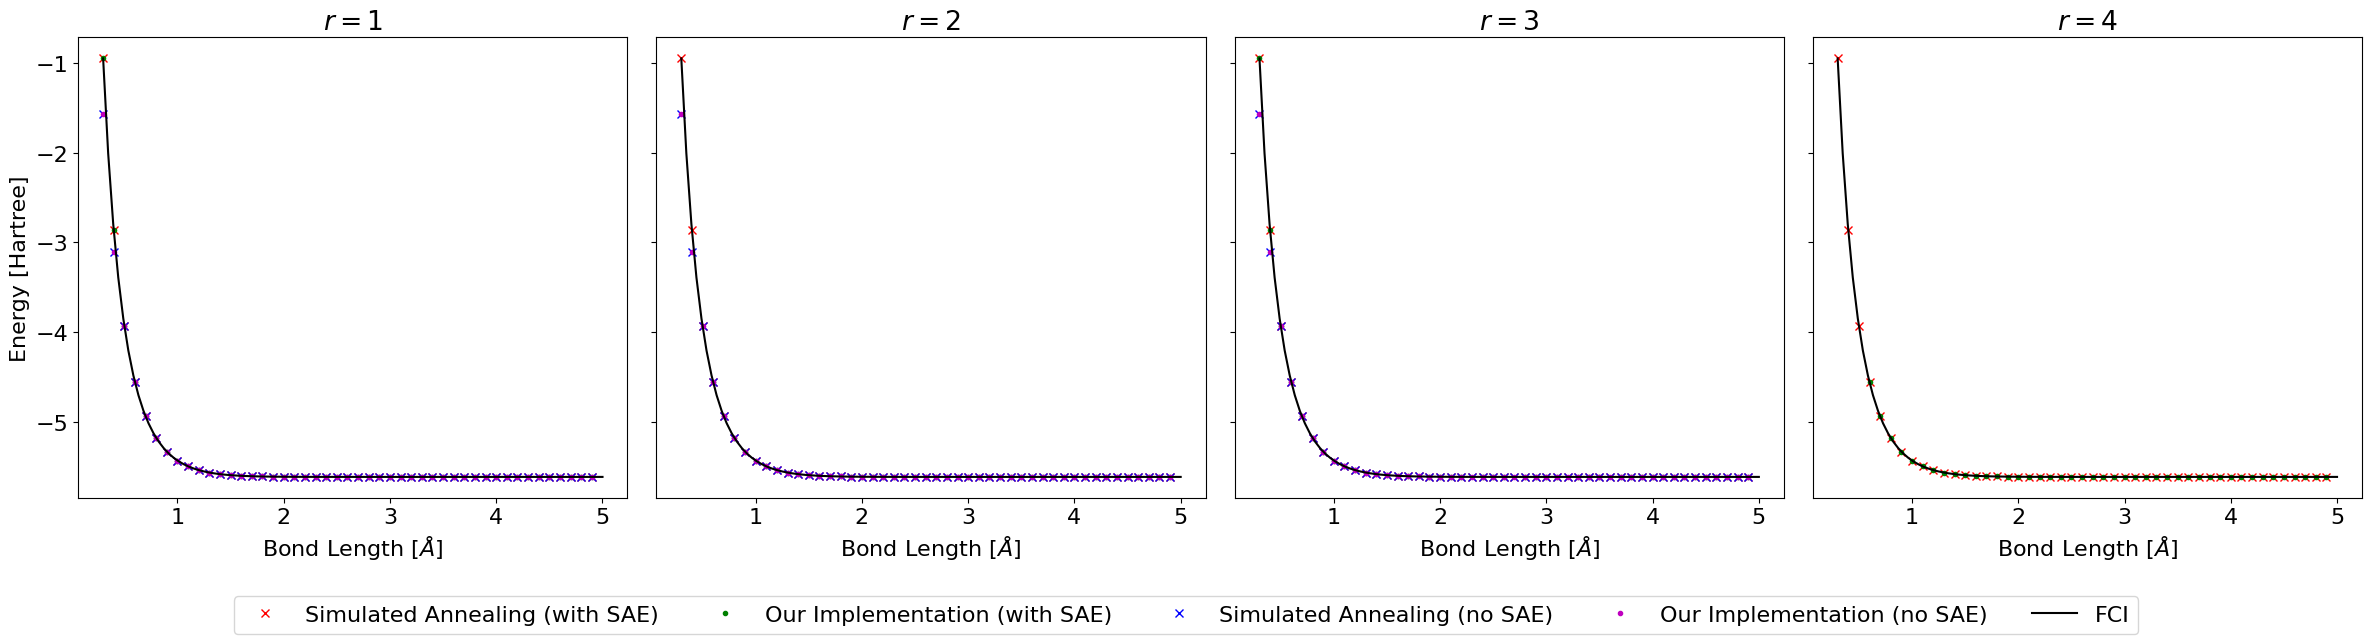

In [ ]:
import matplotlib.pyplot as plt

# Create a single row of subplots, one for each value in sym_r_values
fig, axs = plt.subplots(ncols=len(sym_r_values), nrows=1, figsize=(6*len(sym_r_values), 6), sharex=True, sharey=True)

# Initialize an empty list to store handles and labels for the legend
handles, labels = [], []

# Loop over each r value and plot corresponding energies
for i in range(len(sym_r_values)):
    # Plot the symmetry-adapted case
    l1, = axs[i].plot(bond_lengths, sym_energies[i], 'xr', label="Simulated Annealing (with SAE)")
    
    l1_impl = axs[i].plot(df["Bond Length"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "yes") & (df["R value"] == i+1)], 
                df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "yes") & (df["R value"] == i+1)], ".g", label="Our Implementation (with SAE)")
    
    # Plot the non-symmetry-adapted case if the corresponding r value exists
    if i < len(nosym_r_values):
        l2, = axs[i].plot(bond_lengths, nosym_energies[i], 'xb', label="Simulated Annealing (no SAE)")
        
        l2_impl = axs[i].plot(df["Bond Length"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                        (df["Symmetry Case"] == "no") & (df["R value"] == i+1)], 
                    df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                        (df["Symmetry Case"] == "no") & (df["R value"] == i+1)], ".m", label="Our Implementation (no SAE)")
    
    # Plot the FCI reference energy
    l3, = axs[i].plot(fci_bond_lengths, fci_energies, '-k', label="FCI")
    
    # Collect handles and labels from the first subplot only
    if i == 0:
        handles.extend([l1, l1_impl[0], l2, l2_impl[0], l3])
        labels.extend([l1.get_label(), l1_impl[0].get_label(), l2.get_label(), l2_impl[0].get_label(), l3.get_label()])
    
    # Set titles and labels
    axs[i].set_title(f"$r={sym_r_values[i]}$")
    axs[i].set_xlabel("Bond Length [$\AA$]")
    if i == 0:
        axs[i].set_ylabel("Energy [Hartree]")

# Add the legend below the figure using handles and labels from the first subplot
fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, -0.1))

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plot
plt.show()
